In [ ]:
pip install scikit-image

In [ ]:
import skimage as ski #import and rename the package
import matplotlib.pyplot as plt #plot images
import numpy as np
import skimage.filters as filters
import cv2
import math
from scipy.signal import fftconvolve #function to compute the normalized crosscorrelation

#FUNCTIONS

#turn the RGB images in monochrome
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

#obtain the mask
def masking(cropped,kernel_size=(5, 5)):
 threshold = filters.threshold_otsu(cropped)
 mask=cropped>threshold

 mask_binary = mask.astype(np.uint8) * 255

 #elliptical kernel
 kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
 #closing&opening
 closing = cv2.morphologyEx(mask_binary, cv2.MORPH_CLOSE, kernel)
 opening=cv2.morphologyEx(closing,cv2.MORPH_OPEN,kernel)

 erosion = cv2.erode(opening, kernel, 2)
 edges = cv2.absdiff(erosion, opening)

 plt.figure(figsize=(12, 4))
 plt.subplot(1,3,1)
 plt.imshow(cropped,cmap='gray')
 plt.title('Mole')
 plt.axis('off')

 plt.subplot(1,3,2)
 plt.imshow(opening, cmap='gray')
 plt.title('Segmented_C/O')

 plt.subplot(1,3,3)
 plt.imshow(edges, cmap='gray')
 plt.title('Edges Mole')
 plt.axis('off')
 plt.show()

 return (opening,edges)

#area
def are(opening):
 area=np.sum(opening==0);
 print(f'The area of the mole is: {area} pixels')
 return (area)

#euclidean distance
def distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

#diameter
def diameter (edges):
 coords= np.where(edges == 255)
 #transform this tabulate in a 2d array
 coords=np.transpose(coords)

 distances_=[]
 #distance all points vs all points
 for k in range(len(coords)):
    for y in range(len(coords)):
        if k != y: # doesn't compute distance between one point against itself
            dist_ = distance(coords[k][0], coords[k][1], coords[y][0], coords[y][1])
            distances_.append((k,y,dist_))
            #print(f"Distance between {k} ({coords_mol[k]}) and {y} ({coords_mol[y]}): {dist_}")

 diameter=max(distances_, key = lambda x: x[2]) #[2] element
 k_diameter=diameter[0]
 y_diameter=diameter[1]
 return(coords,k_diameter,y_diameter,diameter)

# traslation+rotation to perform the simmetry analysis
def translate_rotate(mask_binary, coords, i_diameter, ii_diameter):
    # Extract the points P3 and P4
    Pi = [coords[i_diameter][0], coords[i_diameter][1]]
    Pii = [coords[ii_diameter][0], coords[ii_diameter][1]]

    # Recenter the image
    height, width = mask_binary.shape[:2]
    center= (height/2, width/2)

    Pi = np.array(Pi)
    Pii = np.array(Pii)

    # Middle point of the line going through P3 and P4
    Pc = (Pi + Pii) / 2

    # Shift the object to the center
    shift_x = center[1] - Pc[1]
    shift_y = center[0] - Pc[0]

    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])  # Translation matrix
    centered_mask = cv2.warpAffine(mask_binary, M, (width, height))

    Pi_shifted = np.array(Pi) + np.array([shift_y, shift_x])
    Pii_shifted = np.array(Pii) + np.array([shift_y, shift_x])
    Pc_shifted = np.array(Pc) + np.array([shift_y, shift_x])

    # Calculate the direction vector between P3 and P4
    u = Pii_shifted - Pi_shifted
    u_norm = u / np.linalg.norm(u)  # Normalize the direction vector

    # Calculate the angle between u and the horizontal axis
    theta = np.arctan2(u_norm[1], u_norm[0])  # Angle in radians  # Angle in radians
    theta_degrees = np.degrees(theta)  # Convert to degrees
    center= (width/2,height/2)

    # Create the rotation matrix
    rotate_matrix= cv2.getRotationMatrix2D(center=center, angle=-theta_degrees + 90, scale=1)

    # Rotate the centered mask
    rotated_mask = cv2.warpAffine(src=centered_mask, M=rotate_matrix, dsize=(width, height))

    # Rotate the points
    Pi_rotated = np.dot(rotate_matrix, np.array([Pi_shifted[1], Pi_shifted[0], 1]))  # [x', y']
    Pii_rotated = np.dot(rotate_matrix, np.array([Pii_shifted[1], Pii_shifted[0], 1]))
    Pc_rotated = np.dot(rotate_matrix, np.array([Pc_shifted[1], Pc_shifted[0],1]))

    plt.subplot(1, 3, 1)
    plt.imshow(mask_binary, cmap='gray')
    plt.plot(Pi[1],Pi[0],'o')
    plt.plot(Pii[1],Pii[0],'o')
    plt.plot(Pc[1],Pc[0],'o')
    plt.plot([Pi[1],Pii[1]],[Pi[0],Pii[0]],color='red')
    plt.axvline(Pc[1], color ="green", linestyle ="--")
    plt.axhline(Pc[0], color ="green", linestyle ="--")
    plt.axvline(center[0], color ="red", linestyle ="--")
    plt.axhline(center[1], color ="red", linestyle ="--")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(centered_mask, cmap='gray')
    plt.plot(Pi_shifted[1], Pi_shifted[0], 'o')  # Pi shifted
    plt.plot(Pii_shifted[1], Pii_shifted[0], 'o')  # Pii shifted
    plt.plot(Pc_shifted[1], Pc_shifted[0], 'o')  # Center shifted
    plt.axvline(Pc_shifted[1], color ="green", linestyle ="--")
    plt.axhline(Pc_shifted[0], color ="green", linestyle ="--")
    plt.axvline(center[0], color="red", linestyle="--")
    plt.axhline(center[1], color="red", linestyle="--")


    plt.subplot(1, 3, 3)
    plt.imshow(rotated_mask, cmap='gray')
    plt.plot(Pi_rotated[0], Pi_rotated[1], 'o')  #Pi rotated
    plt.plot(Pii_rotated[0], Pii_rotated[1], 'o')  # Pi rotated
    plt.plot(Pc_rotated[0], Pc_rotated[1], 'o')  # Center rotated
    plt.plot([Pi_rotated[0], Pii_rotated[0]], [Pi_rotated[1], Pii_rotated[1]], color='red')
    plt.axvline(Pc_rotated[0], color="green", linestyle="--")
    plt.axhline(Pc_rotated[1], color="green", linestyle="--")

    plt.show()
    # Return the transformed image and the rotated points
    return rotated_mask, Pi_rotated, Pii_rotated, Pc_rotated, Pi_shifted, Pii_shifted, Pc_shifted,theta_degrees

#crosscorrelation
########################################################################################
# Author: Ujash Joshi, University of Toronto, 2017                                     #
# Based on Octave implementation by: Benjamin Eltzner, 2014 <b.eltzner@gmx.de>         #
# Octave/Matlab normxcorr2 implementation in python 3.5                                #
# Details:                                                                             #
# Normalized cross-correlation. Similiar results upto 3 significant digits.            #
# https://github.com/Sabrewarrior/normxcorr2-python/master/norxcorr2.py                #
# http://lordsabre.blogspot.ca/2017/09/matlab-normxcorr2-implemented-in-python.html    #
########################################################################################

def normxcorr2(template, image, mode="full"):
    # If this happens, it is probably a mistake
    if np.ndim(template) > np.ndim(image) or \
            len([i for i in range(np.ndim(template)) if template.shape[i] > image.shape[i]]) > 0:
        print("normxcorr2: TEMPLATE larger than IMG. Arguments may be swapped.")

    template = template - np.mean(template)
    image = image - np.mean(image)

    a1 = np.ones(template.shape)
    # Faster to flip up down and left right then use fftconvolve instead of scipy's correlate
    ar = np.flipud(np.fliplr(template))
    out = fftconvolve(image, ar.conj(), mode=mode)

    image = fftconvolve(np.square(image), a1, mode=mode) - \
            np.square(fftconvolve(image, a1, mode=mode)) / (np.prod(template.shape))

    # Remove small machine precision errors after subtraction
    image[np.where(image < 0)] = 0

    template = np.sum(np.square(template))
    with np.errstate(divide='ignore',invalid='ignore'):
        out = out / np.sqrt(image * template)

    # Remove any divisions by 0 or very close to 0
    out[np.where(np.logical_not(np.isfinite(out)))] = 0
    return out

#measure the distance from each border pixel to the largest diameter (horizontal one) and compare between the two halves.
def border_d(side,kernel_size=(4,4)):

 threshold_side = filters.threshold_otsu(side)
 mask_side=side>threshold_side
 mask_binary_side = mask_side.astype(np.uint8) * 255

 kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
 erosion_side = cv2.erode(mask_binary_side, kernel, 2)
 edges_side = cv2.absdiff(erosion_side, mask_binary_side)

 a=edges_side
 #plt.imshow(a, cmap='gray')
 coords_a = np.argwhere(a == 255)
 max = np.max(coords_a[:, 0])

 distances_a=[]

 for k in range(len(coords_a)):
            dist_a = distance(coords_a[k][1], coords_a[k][0],coords_a[k][1],max)
            distances_a.append((dist_a))
            #vd
 average_dist_a=np.mean( distances_a)
 print(f'The average distance is: {average_dist_a} pixels')
 return (average_dist_a,coords_a)

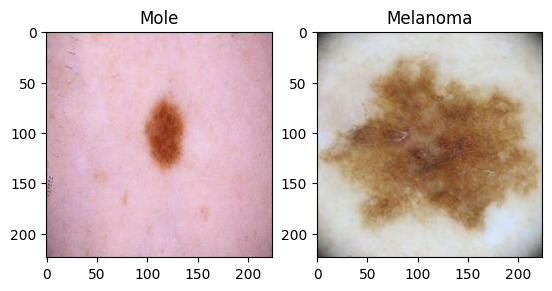

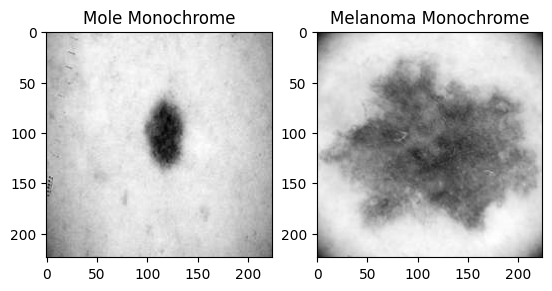

In [ ]:
#PLOT
# read and visualize the image
image_mol='/content/6317.jpg' #benign
mole=ski.io.imread(image_mol)
image_mel = '/content/5650.jpg' #malignant
melanoma = ski.io.imread(image_mel)

plt.subplot(1,2,1)
plt.imshow(mole)
plt.title('Mole')
plt.subplot(1,2,2)
plt.title('Melanoma')
plt.imshow(melanoma)
plt.show()

#convert the image to monochrome
mole_gray = rgb2gray(mole)
melanoma_gray = rgb2gray(melanoma)

plt.subplot(1,2,1)
plt.imshow(mole_gray, cmap=plt.get_cmap('gray'))
plt.title('Mole Monochrome')
plt.subplot(1,2,2)
plt.imshow(melanoma_gray, cmap=plt.get_cmap('gray'))
plt.title('Melanoma Monochrome')
plt.show()

In [ ]:
#crop the images to obtain only the segmentation on the object
cropped_mol=mole_gray[0:250, 52:180]
cropped_mel=melanoma_gray[25:200, 4:250]

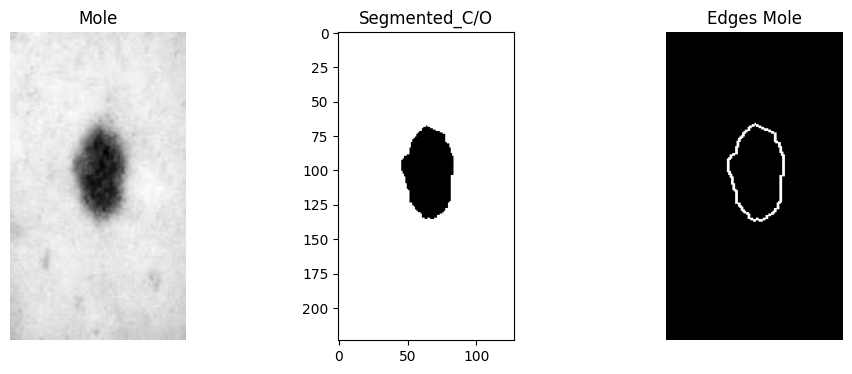

In [ ]:
###MOLE###
#masking
opening_mol,edges_mol = masking(cropped_mol,kernel_size=(5,5))

In [ ]:
#area
area_mol=are(opening_mol)

In [ ]:
#diameter
coords_mol,k_diameter_mol,y_diameter_mol,diameter_mol=diameter(edges_mol)
print(f'The diameter of the mole is: {diameter_mol[2]} pixels')


The diameter of the mole is: 71.17583859709698 pixels


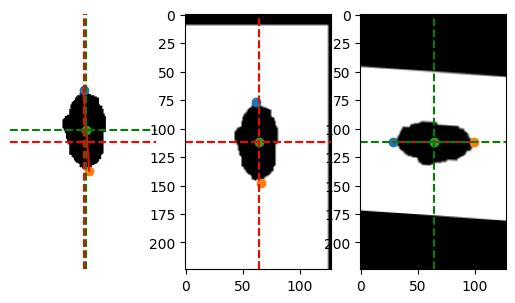

In [ ]:
#asimmetry
mol_rotated, P1_rotated, P2_rotated, Pcmol_rotated, P1_shifted, P2_shifted, Pcmol_shifted,theta_degrees_mol=translate_rotate(opening_mol, coords_mol, k_diameter_mol, y_diameter_mol)

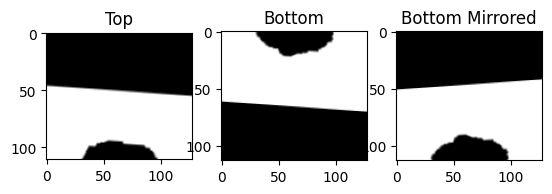

(-0.5, 127.5, 52.5, -0.5)

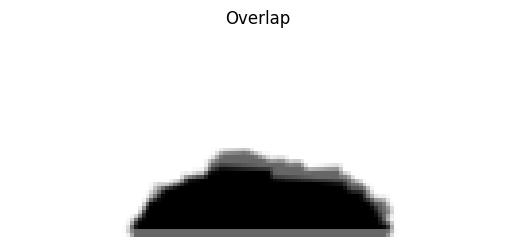

In [ ]:
top_ = mol_rotated[:int(Pcmol_rotated[1]),:]
bottom_ = mol_rotated[int(Pcmol_rotated[1]):,:]
bottom_mirrored_=np.flipud(bottom_)

plt.subplot(1,3,1)
plt.imshow(top_,cmap='gray')
plt.title('Top')
plt.subplot(1,3,2)
plt.imshow(bottom_,cmap='gray')
plt.title('Bottom')
plt.subplot(1,3,3)
plt.title('Bottom Mirrored')
plt.imshow(bottom_mirrored_,cmap='gray')

plt.show()
plt.imshow(top_[60:,:],cmap='gray')
plt.imshow(bottom_mirrored_[60:,:],cmap='gray',alpha=0.6)
plt.title('Overlap')
plt.axis('off')


In [ ]:
###compute crosscorrelation
out_ = normxcorr2(top_[60:,:], bottom_mirrored_[60:,:],mode='full')
print(f'The crosscorrelation between the two halves of the mole is: {np.max(out_)}')

The crosscorrelation between the two halves of the mole is: 0.9554553457042678


In [ ]:
#average distance of border's pixel from the diameter
[average_dist_top_,coords_a]=border_d(top_[60:,:])
[average_dist_bottom_,coords_b]=border_d(bottom_mirrored_[60:,:])

average_dist_mol=abs(average_dist_top_- average_dist_bottom_)
print(f'The difference between the average distances of the two halves from the diameter of the mole is: {average_dist_mol} pixels')


The average distance is: 10.179487179487179 pixels
The average distance is: 13.345323741007194 pixels
The difference between the average distances of the two halves from the diameter of the mole is: 3.165836561520015 pixels


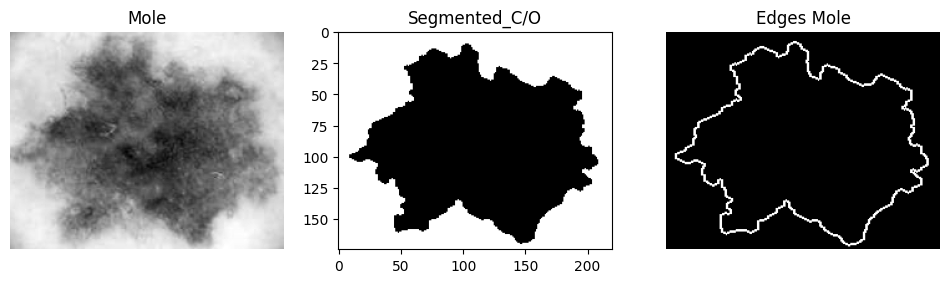

In [ ]:
####MELANOMA###
#masking
opening_mel,edges_mel = masking(cropped_mel,kernel_size=(5,5))

In [ ]:
#area
area_mel=are(opening_mel)

The area of the mole is: 18973 pixels


In [ ]:
#diameter
coords_mel,k_diameter_mel,y_diameter_mel,diameter_mel=diameter(edges_mel)
print(f'The diameter of the melanoma is: {diameter_mel[2]} pixels')

The diameter of the melanoma is: 203.19940944796076 pixels


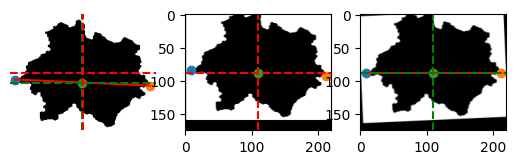

In [ ]:
#asimmetry
mel_rotated, P3_rotated, P4_rotated, Pcmel_rotated, P3_shifted, P4_shifted, Pcmel_shifted,theta_degrees_mel=translate_rotate(opening_mel, coords_mel, k_diameter_mel, y_diameter_mel)

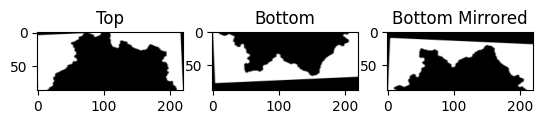

(-0.5, 219.5, 67.5, -0.5)

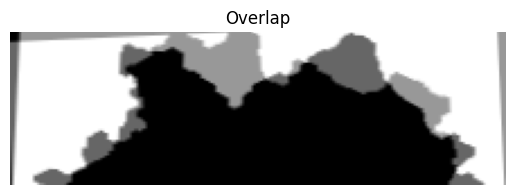

In [ ]:
top = mel_rotated[:int(Pcmel_rotated[1]),:]
bottom = mel_rotated[int(Pcmel_rotated[1]):,:]
bottom_mirrored=np.flipud(bottom)

plt.subplot(1,3,1)
plt.imshow(top,cmap='gray')
plt.title('Top')
plt.subplot(1,3,2)
plt.imshow(bottom,cmap='gray')
plt.title('Bottom')
plt.subplot(1,3,3)
plt.title('Bottom Mirrored')
plt.imshow(bottom_mirrored,cmap='gray')

plt.show()
plt.imshow(top,cmap='gray')
plt.imshow(bottom_mirrored[20:,:],cmap='gray',alpha=0.6)
plt.title('Overlap')
plt.axis('off')

In [ ]:
###compute crosscorrelation
out=normxcorr2(top, bottom_mirrored,mode='full')
print(f'The crosscorrelation between the two halves of the melanoma is: {np.max(out)}')

The crosscorrelation between the two halves of the melanoma is: 0.6027841611735237


In [ ]:
#average distance of border's pixel from the diameter
[average_dist_top,coords_c]=border_d(top[:,5:215],kernel_size=(4,4))
[average_dist_bottom,coords_d]=border_d(bottom_mirrored[20:,5:],kernel_size=(4,4))

average_dist_mel=abs(average_dist_top - average_dist_bottom)
print(f'The difference between the average distances of the two halves from the major diameter of the melanoma is: {average_dist_mel} pixels')

The average distance is: 57.04050279329609 pixels
The average distance is: 36.802083333333336 pixels
The difference between the average distances of the two halves from the major diameter of the melanoma is: 20.238419459962756 pixels
